<font color=#0099ff size=6 face="黑体">迁移学习</font>  
<font color=#0000FF size=4 face="微软雅黑">&emsp;&emsp;在完成猪脸识别的过程中使用到了迁移学习的思想，所以呢，在展示代码之前，我先解释一下视觉领域迁移学习的应用：  
1.为什么要使用迁移学习？  
&emsp;&emsp;迁移学习是一个很不错的方法，无论是语音、图片，还是文本处理，都有迁移学习的应用场景和实例，借助现有学习到的知识，能够很好的解决目标问题；  
2.fine tune和Transfer Learning的关系？  
&emsp;&emsp;李宏毅老师按照源问题数据集和目标问题数据集是否有标签，可以像下图这样划分，方格中是典型的方法技巧，当然这种分类的标准有很多，我只找了这一种  
<img src="images/17.jpg" style="width:450px;height:300px;">
<caption><center> <u> <font color='purple'> **迁移学习划分** </u></center></caption>  
3.关于fine tune  
&emsp;&emsp;应用场景是我们在target（猪脸图片）上有少量的label data，如何有效利用这部分label data，而且还不过拟合呢，我们可以利用原问题（inception-v3用来做狗种类的识别）中学习到的CNN，在target上采用保守学习的方式，使神经网络中间的参数保持不变，或者tune的时候，只tune某几层，其他层的参数不发生变化；  
4.keras微调的方式：  
fine-tuning方式一：使用预训练网络的bottleneck feature  
fine-tuning方式二：要调整权重，并训练  
5.关于bottleneck  
<img src="images/18.png" style="width:400px;height:800px;">
<caption><center> <u> <font color='purple'> **bottleneck feature** </u></center></caption>  
下面开始猪脸识别！！！
</font>  

In [1]:
import os
import sys
import glob
import argparse
import matplotlib.pyplot as plt

from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
def get_nb_files(directory):
  """Get number of files by searching directory recursively"""
  if not os.path.exists(directory):
    return 0
  cnt = 0
  for r, dirs, files in os.walk(directory):
    for dr in dirs:
      cnt += len(glob.glob(os.path.join(r, dr + "/*")))
  return cnt
# get_nb_files('/home/keras/animal5/train')

In [3]:
# 数据准备
IM_WIDTH, IM_HEIGHT = 299, 299 #InceptionV3指定的图片尺寸
FC_SIZE = 1024                # 全连接层的节点个数
NB_IV3_LAYERS_TO_FREEZE = 128  # 冻结层的数量


train_dir = 'E:/智能控制理论与方法-研究生/database/train_img'  # 训练集数据
val_dir = 'E:/智能控制理论与方法-研究生/database/val_img' # 验证集数据
nb_classes= 30
nb_epoch = 2
batch_size = 20

nb_train_samples = get_nb_files(train_dir)      # 训练样本个数
nb_classes = len(glob.glob(train_dir + "/*"))  # 分类数
nb_val_samples = get_nb_files(val_dir)       #验证集样本个数
nb_epoch = int(nb_epoch)                # epoch数量
batch_size = int(batch_size)

#　图片生成器
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)
test_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# 训练数据与测试数据
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(IM_WIDTH, IM_HEIGHT),
batch_size=batch_size,class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
val_dir,
target_size=(IM_WIDTH, IM_HEIGHT),
batch_size=batch_size,class_mode='categorical')

Found 18099 images belonging to 30 classes.
Found 1837 images belonging to 30 classes.


In [4]:
# 添加新层
def add_new_last_layer(base_model, nb_classes):
  """
  添加最后的层
  输入
  base_model和分类数量
  输出
  新的keras的model
  """
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
  predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
  model = Model(input=base_model.input, output=predictions)
  return model

In [5]:
# 冻上base_model所有层，这样就可以正确获得bottleneck特征
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
#冻上NB_IV3_LAYERS之前的层
def setup_to_finetune(model):
  """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.

  note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch

  Args:
    model: keras model
  """
  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
#设置网络结构
setup_to_finetune(model)

# 模式二训练
history_ft = model.fit_generator(
train_generator,
samples_per_epoch=nb_train_samples,
nb_epoch=nb_epoch,
validation_data=validation_generator,
nb_val_samples=nb_val_samples,
class_weight='auto')

# 模型保存
model.save('my_model_inceptionv3_fine2.h5')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=2, validation_data=<keras.pre..., validation_steps=1837, steps_per_epoch=904, class_weight="auto")`


Epoch 1/2
905/904 [==============================] - 3765s 4s/step - loss: 1.5118 - acc: 0.5436 - val_loss: 0.8605 - val_acc: 0.8204
Epoch 2/2
905/904 [==============================] - 3730s 4s/step - loss: 0.3312 - acc: 0.8986 - val_loss: 0.4538 - val_acc: 0.8928


In [23]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.figure(1)
  plt.plot(epochs, acc, 'g')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  plt.figure(2)
  plt.plot(epochs, loss, 'r')
  plt.plot(epochs, val_loss, 'g-')
  plt.title('Training and validation loss')
  plt.show()

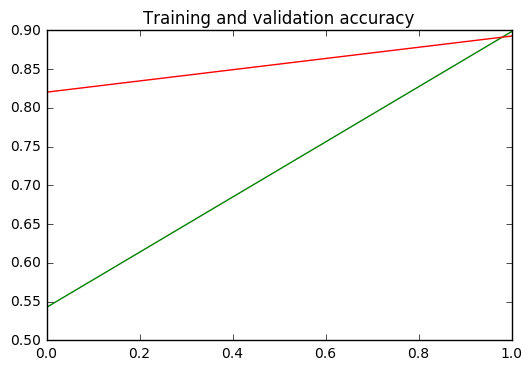

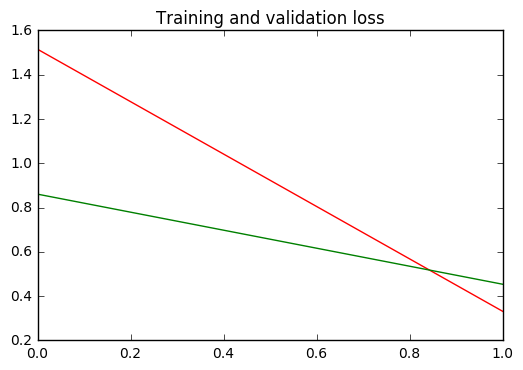

In [24]:
plot_training(history_ft)

In [25]:
#冻上NB_IV3_LAYERS之前的层
def setup_to_finetune1(model):
  """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.

  note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch

  Args:
    model: keras model
  """
  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
#设置网络结构
setup_to_finetune1(model)

# 模式二训练
history_ft = model.fit_generator(
train_generator,
samples_per_epoch=nb_train_samples,
nb_epoch=nb_epoch,
validation_data=validation_generator,
nb_val_samples=nb_val_samples,
class_weight='auto')

# 模型保存
model.save('my_model_inceptionv3_fine2_adam.h5')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=2, validation_data=<keras.pre..., validation_steps=1837, steps_per_epoch=904, class_weight="auto")`


Epoch 1/2
905/904 [==============================] - 3779s 4s/step - loss: 0.1963 - acc: 0.9402 - val_loss: 0.1760 - val_acc: 0.9428
Epoch 2/2
905/904 [==============================] - 3762s 4s/step - loss: 0.1342 - acc: 0.9575 - val_loss: 0.0995 - val_acc: 0.9690


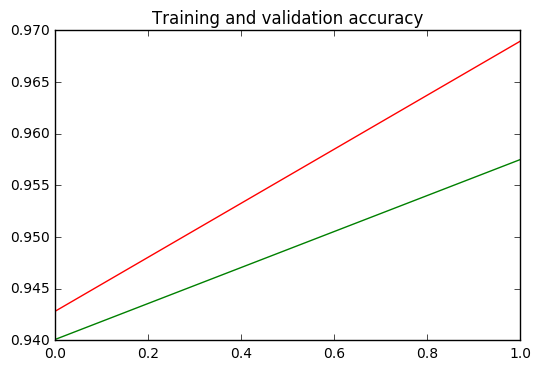

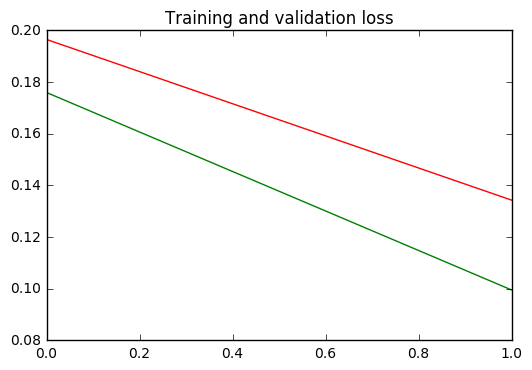

In [27]:
plot_training(history_ft)

In [28]:
# 定义网络框架
base_model = InceptionV3(weights='imagenet', include_top=False) # 预先要下载no_top模型
model = add_new_last_layer(base_model, nb_classes)              # 从基本no_top模型上添加新层
setup_to_transfer_learn(model, base_model)                      # 冻结base_model所有层

# 模式一训练
history_tl = model.fit_generator(
train_generator,
nb_epoch=nb_epoch,
samples_per_epoch=nb_train_samples,
validation_data=validation_generator,
nb_val_samples=nb_val_samples,
class_weight='auto')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=2, validation_data=<keras.pre..., validation_steps=1837, steps_per_epoch=904, class_weight="auto")`


Epoch 1/2
905/904 [==============================] - 2091s 2s/step - loss: 1.6519 - acc: 0.5409 - val_loss: 1.0278 - val_acc: 0.6897
Epoch 2/2
905/904 [==============================] - 2084s 2s/step - loss: 0.9109 - acc: 0.7270 - val_loss: 0.6429 - val_acc: 0.8078


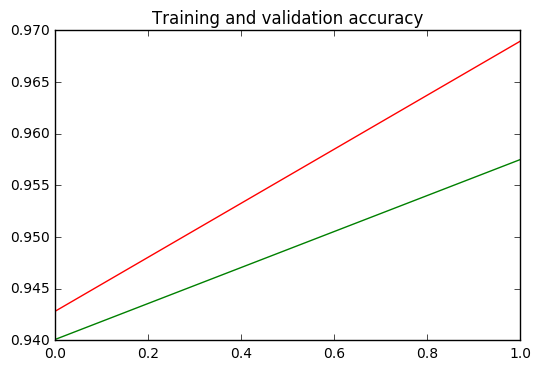

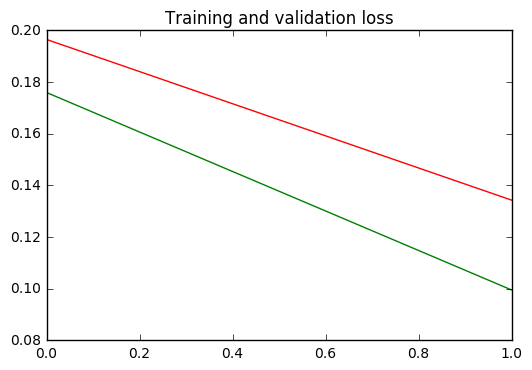

In [29]:
plot_training(history_ft)